#### Submission for HSF GSoC Program - Jian Park

#### Imports

In [ ]:
# Import classes from other files
from utils.dataStorage import DataStorage
from utils.model import EdgeModel

In [2]:
# Imports for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import for file handling & math
from pathlib import Path
import pandas as pd
import random

# Torch imports
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from torch_geometric.loader import DataLoader

#### Obtaining the training data

In [4]:
# Load all batches into dataset a dataStorage class (note dataStorage automatically performs train-test split)
dataset = DataStorage(Path("./dataset/batch_1_" + str(9)))
for i in range(9):
    dataset.append(Path("./dataset/batch_1_" + str(i)))

# Batch dataset using DataLoader with shuffling
loader = DataLoader(dataset, batch_size=4, shuffle=True)

#### Preliminary analysis of training data

Let's start by doing some quick analysis on what the data looks like.

In [5]:
print("Number of graphs in training set:", len(dataset))
print("Set of keys in each graph", dataset[0].keys)

Number of graphs in training set: 7996
Set of keys in each graph ['edge_attr', 'edge_index', 'y', 'x']


In [6]:
# Get the number of features in each node/edge
print("Number of node features:", dataset[0].num_node_features)
print("Number of edge features:", dataset[0].num_edge_features)
print("Is this graph undirected? ", dataset[0].is_undirected())

Number of node features: 6
Number of edge features: 4
Is this graph undirected?  False


In [7]:
# Observe the size and sparsity of the graph
edges_average, nodes_average = 0, 0
for i in range(100):
    edges_average += dataset[i].num_edges
    nodes_average += dataset[i].num_nodes

print("Average number of nodes in first 100 graphs:", nodes_average/100)
print("Average number of edges in first 100 graphs:", edges_average/100)

Average number of nodes in first 100 graphs: 296.68
Average number of edges in first 100 graphs: 3810.04


In [8]:
# Test to see if there are any imbalance in labels
percent_average = 0
for i in range(100):
    percent_average += (dataset[i]['y'].sum()/len(dataset[i]['y'])).item()

print("Proportion of edges that are positively labeled in first 100 graphs:", percent_average/100)

Proportion of edges that are positively labeled in first 100 graphs: 0.20037899509072304


We can make a few observations from these results. 

First, this dataset contains 10000 graphs with a few hundred nodes and a few thousand undirected edges. This suggests that the graphs are relatively sparse (approximately 5% of all possible edges), which could be useful information. 

Second, each node has 6 dimensions in its feature, while each edge has 4 dimensions.

Lastly, we can observe there is a class imbalance in how each edge is classified; only about 20% of edges are classified as positive, while the rest are classified as negatie. This means that a model we train may be risk of generating low loss values by consisently predicting values close to 0. We will try to see if we can train a model to avoid doing this.

### Initialize & Train Model

Now let's train the model on the training data using the EdgeModel class (found inside the utils folder). We select the loss function to be binary_cross_entropy_with_logits with a weight of 4 added to positive cases in order to best reflect the 20%-80% disproportionality of edge classifications.

In [21]:
device = torch.device('cpu')

# Create an EdgeModel model
model = EdgeModel(dataset[0]).to(device)

# Use the Adam optimizer with learning rate 0.0025, weight_decay 0.0001 (roughly determined by looking at rate of convergence for the model loss)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025, weight_decay=1e-4)

In [24]:
# Note: Training takes approximately 1-2 minutes

# List to store set of loss values
loss_values = []

# Set model to begin training
model.train()

for batch in loader:
    data = batch.to(device)

    # Reset gradients to begin new training round
    optimizer.zero_grad()

    # Make a forward pass using data
    out = model(data)

    # Use BCE function to calculate loss between target data.y and out
    # For positive cases a weight of 4 is added to reflect the approximately 20%-80% imbalance in positive classifications
    loss = binary_cross_entropy_with_logits(out, data.y, pos_weight=torch.Tensor([4]))
    loss_values.append(loss.item())

    # Perform backpropogation using loss value
    loss.backward()

    # Update all weights/biases based on gradient results
    optimizer.step()

print("Final Loss: " + str(loss_values[-1]))

Final Loss: 0.417093425989151


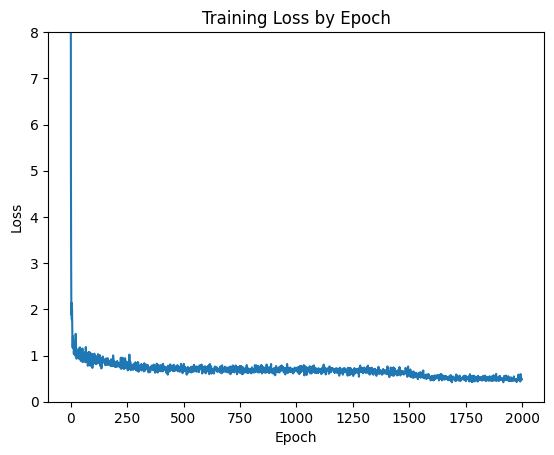

In [23]:
# Visualize loss over epochs
sns.lineplot(y=loss_values, x=range(len(loss_values)))

plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.ylim(0, 8)

plt.show()

#### Evaluate Model

To verify whether our model has truly learned or if our low loss values are simply a result of label imbalance, we will compare our model's test data loss to that of a naive model that assigns a constant prediction to each edge. We will determine this constant by finding the value that minimizes the test data loss.

In [25]:
# Constant to determine how finely to check for naive solutions. 10 means we check the average loss when the constant is 0, 0.1, 0.2, ...
granularity = 10

# Lists to store naive losses and our model's loss for each graph in the test set
model_losses = []
naive_losses = []
for i in range(granularity):
    naive_losses.append([])

model.eval()
for test_index in range(dataset.test_len()):
    # Get n-th graph in the test set
    data = dataset.test_get(test_index).to(device)

    # Add model loss to list
    out = model(data)
    model_losses.append(binary_cross_entropy_with_logits(out, data.y, pos_weight=torch.Tensor([4])))

    # Add each loss from naive model to the naive loss list
    for i in range(granularity):
        test_tensor = (i/granularity) * torch.ones(len(data.y))
        loss = binary_cross_entropy_with_logits(test_tensor, data.y, pos_weight=torch.Tensor([4]))
        naive_losses[i].append(loss.item())


In [26]:
# Determine the naive strategy that minimizes the loss in the test data, get its loss
naive_loss = 10
min_multiple = -1
for i in range(granularity):
    if sum(naive_losses[i])/len(naive_losses[i]) < naive_loss:
        naive_loss = sum(naive_losses[i])/len(naive_losses[i])
        min_multiple = i/granularity

# Calculate average loss of the model across the test data
model_loss = (sum(model_losses)/len(model_losses)).item()

print("Best Naive loss on test data: " + str(naive_loss))
print("Occurs at prediction value " + str(min_multiple))

print("Model loss on test data: " + str(model_loss))
print("Factor of improvement over Naive strategy: " + str(100 - round(model_loss/naive_loss * 1000)/10) + "%")

Best Naive loss on test data: 1.1071341426074506
Occurs at prediction value 0.0
Model loss on test data: 0.4606042802333832
Factor of improvement over Naive strategy: 58.4%


Lets take a closer look at how this model performs by creating logistic regressions of sample graphs in the test dataset

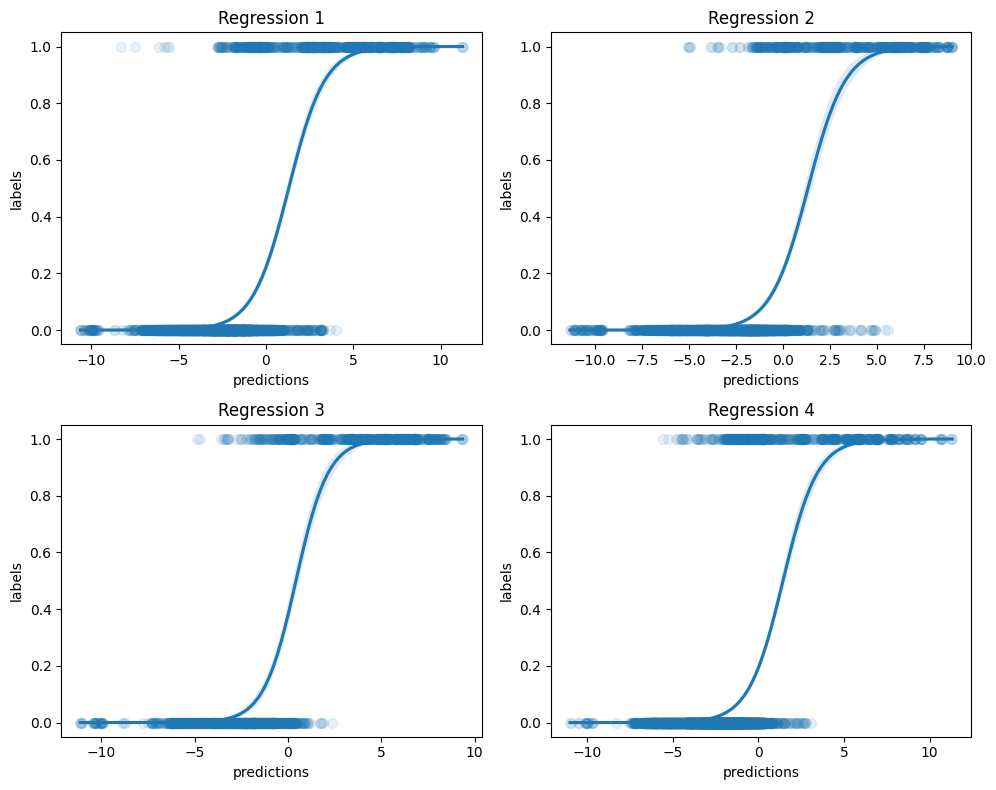

In [27]:
# Get graph data of four arbitrarily chosen graph in the test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    # Choose a random index from the test set
    index = round(dataset.test_len() * random.random())
    data = dataset.test_get(index)
    labels = dataset.test_get(index)['y']
    predictions = model(data)

    # Convert tensors to pandas DataFrames
    df = pd.DataFrame({'labels': labels.detach().numpy(), 'predictions': predictions.detach().numpy()})

    # Plot logistic regression of predicted and label values on the current subplot
    sns.regplot(x='predictions', y='labels', data=df, logistic=True, scatter_kws={"s": 50, "alpha": 0.1}, ax=ax)
    ax.set_title(f"Regression" + str(i + 1))

plt.tight_layout()
plt.show()

Based on these results, our model exhibits notably better performance when compared to a naive strategy. On the test data set, our model yields a loss that is approximately 60% lower than the best naive strategy, indicating that the model is capable of non-trivial classification of edges based on graph attributes.

Furthermore, the logistic regression visualizations demonstrate that the model is effectively classifying edges. Across multiple graphs, we observe that the model excels in classifying negative edges, and also a substantial proportion of positive edges are accurately classified as positive. The model's efficacy in classifying negative edges is likely due to the imbalance in edge classifications within the dataset (80% negative, 20% positive).

#### Conclusions:

In this model development excercise, we observed that the the provided training data possessed an imbalance in edge classifications. To train a model that best accounts for this factor, we modified the normal binary cross-entropy to apply a 4x weight to positive cases in order to more heavily weight negative consequences of improperly predicting positive cases. Additionally, we compared our model to a collection of naive strategies in order to ensure that our model was not merely selecting a value which universally generated a low loss value. 

The model architecture used NNConv layers, also referred to as edge-conditioned convolutions. These layers enabled the model to incorporate edge attribute data while performing convolutions, better utilizing the provided data in the graph.

In the end, our model yielded a loss that was 60% lower than the best naive strategy on the test data set, and visualizations of the predictions do suggest that substantial non-trivial classification is occuring. However the model still suffers from misclassifying many positive edges as negative, likely due to the classification imbalance. As a result, I believe there are a few ways to further improve the performance of this model in the future:

 - Increasing the dataset: The given dataset is not too large, and a larger dataset will almost certainly improve the accuracy of the model as, on the training loss plot, it appears that the model was still learning towards the last epoch. This would additionally help with enabling the model to better learn how to classify positive edges.

 - Hyperparameter tuning: No tools for hyperparameter tuning were used in the interest of time, only rough estimates were used. Utilizing tools like Tune to optimize parameters like the learning rate or the number of layer in the model would likely present model improvements.

 - Different convolution layer types: The NNConv layer was chosen because it appeared best suited for edge classification in comparison to GCNConv, but a further analysis into other convolutional layers offered by PyTorch could prove beneficial.